# Getting Started with BigQuery SQL Searches
First we need to install some packages and load the BigQuery extension. We can run this by clicking on the cell below and then clicking the Run button above.

```

# These commands were run when the notebooks were created by the instructors  but are shown in case you choose to work with these Notebooks later.


#!pip install google.cloud.bigquery
#!pip install google.cloud.storage
#pip3 install --upgrade google-cloud-bigquery
#!pip install google --user
#!pip install --upgrade 'google-cloud-bigquery[bqstorage,pandas]' --user


```

In [ ]:
# Run this command block to install the BigQuery extension.
%load_ext google.cloud.bigquery

# Problem : I want to generate an assembly of Listeria monocytogenes but need sequence data that is almost entirely (90% or more) from that species.
This is a question that can't be answered with Entrez on the NCBI website. You can find data by species but we will not know if it is mislabelled, contaminated, etc. without analysis. You can answer this question with a BigQuery search to find all the runs that meet these requirements and we'll do just that at the end of this notebook.

## Getting Started with a Basic Query
Here is a simple query to find 5 runs submitted for the organsim 'Listeria monocytogenes' from the nih-sra-datastore project. The first line you will see is %%bigquery. This command tells Jupyter to use the bigquery package we just installed. Everything below that line is the SQL query.
This query searches for all (*) columns in the metadata table from the sra database in the project. We will filter for only the rows where the organism name is 'Listeria monocytogenes' and limit the output to only the first 5 rows by using the LIMIT function. 

One limitation of our view in Jupyter is only 20 columns are displayed. At the bottom of the results you will see 5 rows X 36 columns. But if you look closely there are 16 columns that are not visible in the middle of the output chart.

If you are completely new to SQL you might find it helpful to have an SQL cheatsheet handy to refer to. Here is a link to one that covers many of the topics we will discuss but use any that you find easy to read. [SQL Basics Cheat Sheet](https://learnsql.com/blog/sql-basics-cheat-sheet/sql-basics-cheat-sheet-letter.pdf)

In [ ]:
%%bigquery

SELECT distinct(count(acc))
FROM `nih-sra-datastore.sra.metadata`
WHERE organism = 'Listeria monocytogenes'
#LIMIT 5

## SRA Taxonomy Analysis Tool (STAT)
The contents of a sequence data submission is often quite large and can sometimes contains either multiple species like a metagenomic study or can be mislabelled or contaminated. A standardized taxonomic survey of the contents of records in the SRA is provided by the STAT tool and you can use this to decide if the record is likely to meet your needs before downloading files. [STAT Description Page](https://www.ncbi.nlm.nih.gov/sra/docs/sra-taxonomy-analysis-tool/)
The output of this tool has been stored in the sra_tax_anaylysis_tool database.

## Searching Tables in the STAT Database
You will be using the Taxonomy Database Identifier (tax ID) to search the results from the STAT tool later so you need to find the tax ID for Listeria monocytogenes. You can find the tax_id for any entry in the taxonomy table using a search like the one below. 

In [ ]:
%%bigquery

SELECT * 
FROM `nih-sra-datastore.sra_tax_analysis_tool.taxonomy`
WHERE sci_name = 'Listeria monocytogenes'


## Finding How the Database is Organized and Listing Columns
You might already be asking the question of how you would know what columns to search and what the expected contents of the results would be for these databases. Knowing what the columns names are and the datatypes will be important when writing queries. For example SQL requires quotes around string values in searches but no quotes for integers. Here is the structure of databases and tables in the nih-sra-datastore.
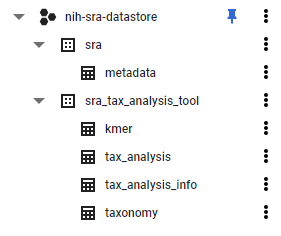

We can use the query below to get a listing of the columns in the database schema as well as what type of data is in them. For a text description of the contents of a column you can go to the SRA documentation page. <https://www.ncbi.nlm.nih.gov/sra/docs/sra-cloud-based-examples/>

In [ ]:
%%bigquery

SELECT table_name, column_name, data_type 
FROM `nih-sra-datastore.sra`.INFORMATION_SCHEMA.COLUMNS

## Listing Tables in a Database
The `nih-sra-datastore.sra` database only has a single table but the STAT database has multiple tables. We can list each using this query.

In [ ]:
%%bigquery

SELECT * 
FROM `nih-sra-datastore.sra_tax_analysis_tool`.INFORMATION_SCHEMA.TABLES

## Listing All Columns in the SRA Tax Analysis Tool Database
The STAT database has more tables than we saw in the metadata table but they are stored in multiple tables. The query we used to list the metadata columns will also work for the STAT database.  

In [ ]:
%%bigquery

SELECT table_name, column_name, data_type 
FROM `nih-sra-datastore.sra_tax_analysis_tool`.INFORMATION_SCHEMA.COLUMNS

## Joining Two (or more) Tables
Using a JOIN command will allow you to combine two different tables to find the information you are looking for. This allows data to be stored most efficiently in the database but also allows a user to view the information in a way they find easiest to understand. 
When joining two or more tables we will need to tell the database which columns in the two tables are expected to align or have the same content. We need a field that can be used to link each table. This value is what we are joining "on" in the statement. In this case we are using 'organism' from the metadata table and 'sci_name' from the taxonomy table. Often in a database the columns used to join two tables will have the same name. But that is not always the case, this is one example.
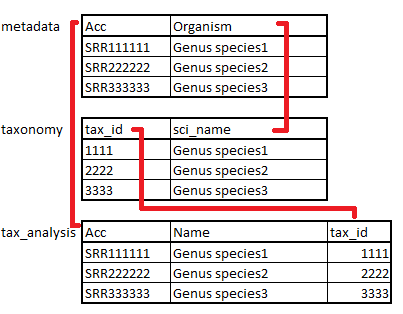

Below we'll combine the two queries from earlier. When specifying multiple tables to search we can also give an abbreviated name to the table ('meta' and 'tax' in the query below) to make the rest of the query easier to type and read.

In [ ]:
%%bigquery

SELECT *
FROM `nih-sra-datastore.sra.metadata` meta 
    JOIN `nih-sra-datastore.sra_tax_analysis_tool.taxonomy` tax
    ON meta.organism = tax.sci_name
WHERE tax.tax_id = 1639
    AND meta.organism = 'Listeria monocytogenes'
LIMIT 5

## How to Show Only the Columns You Want to See
Using * in the select statement will show all the columns in the table. Often you don't need or want all of the columns so you can show only the columns you are interested in. You do this by listing the desired columns in the select statement. These can be from more than one table (for example taxonomy and metadata) as well.

In [ ]:
%%bigquery

SELECT meta.acc, meta.assay_type, meta.instrument, meta.libraryselection, meta.librarysource, meta.organism, tax.sci_name
FROM `nih-sra-datastore.sra.metadata` meta 
    JOIN `nih-sra-datastore.sra_tax_analysis_tool.taxonomy` tax
    ON meta.organism = tax.sci_name
WHERE tax.tax_id = 1639
    AND meta.organism = 'Listeria monocytogenes'
    AND meta.assay_type = 'RNA-Seq'
    AND meta.consent = 'public'
LIMIT 5

## Putting it all Together
Now let's go back to the original problem of someone who wants to do an alignment. We will combine some ideas from before as well as add some math into the search. To use the PGAP package from NCBI you will want data that has a high percentage (we'll use 90% as our minimum) of only one species to generate the assembly and annotation. We can use the output from STAT to do this. 

We want to make an assembly and annotation for Listeria monocytogenes and need sequence data from SRA. 
1. We'll use the taxid (1639) to search the tax_id column in the tax_analysis table. 
2. To know what proportion of the spots have been identified to the taxid we are searching for, we also need to use the total analyzed_spot_count from the tax_analysis_info table for each run. 
3. We will need to join these two tables on the run accession (acc) to run this query.

Finally we can sort by the proportion of the spots that were identified as being from the taxid we want to search.

In [ ]:
%%bigquery

SELECT a.acc, a.name, info.analyzed_spot_count, a.self_count, a.self_count/info.analyzed_spot_count as proportion
FROM `nih-sra-datastore.sra_tax_analysis_tool.tax_analysis` a 
    JOIN `nih-sra-datastore.sra_tax_analysis_tool.tax_analysis_info` info 
    ON a.acc = info.acc
WHERE  a.tax_id = 1639
    AND a.self_count/info.analyzed_spot_count > .9
    AND info.analyzed_spot_count > 100000
ORDER BY proportion DESC

## Taxonomy ID Searches of STAT Results 
Let's take a minute to talk about why the above query can be so useful. If we were to just look for records with the organism as 'Listeria monocytogenes' we would get almost 51,000 records in the metadata table. Some of them will have little to no sequence data from this organism. There can be many reasons why this would occur but it can make finding data to do analysis on difficult. If we were to look just at the STAT results for every record in the database looking for any data identified from Listeria monocytogenes, we would have over 400,000 records. Many of those results will be a small volume of sequence within metagenomic research. 

 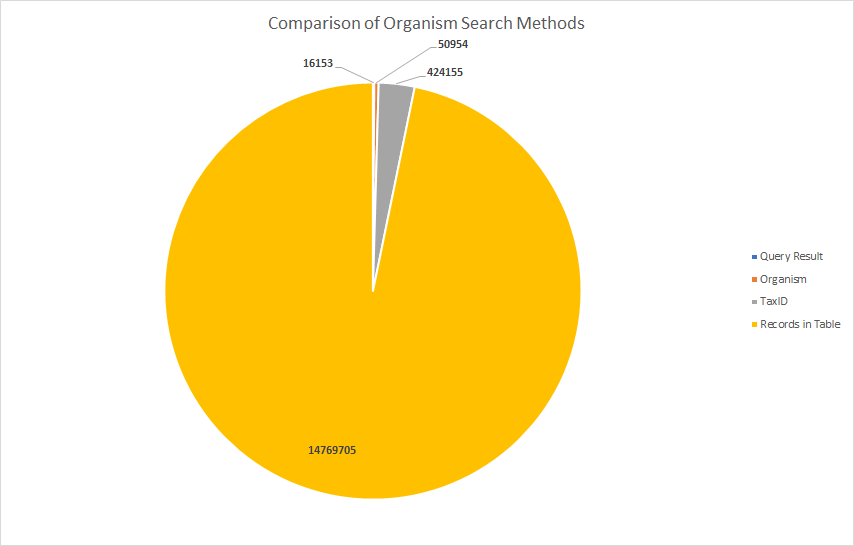

| Method | Hits |
|---------|---------|
| Above Query | 16153 |
| Search using Organism	| 50954 |
| Search using TaxID in STAT | 424155 |
| Unique Accessions in Metadata Table | 14769705 |

The STAT results are not a definitive anaylsis of the contents of the runs because not all species have reference genomes or will be used when anaylyzing the sequence data in SRA. However the tool can be a very fast way to survey the contents of a run to determine if the data contains the species or sets of species you are looking for. You could alter the queries here to look for runs that have a specific list of species or even a minimum number of different species for metagenomic analysis.